# Medical insurance Portfolio project
### Project goals: 
* Analyze our data
* Find out the main features that influence the medical insurance charges
* Model these features to predict changes in charges

## dataset exploration/overview:

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # remove seaborn future warning above plots
sns.set()

In [199]:
insurance_df = pd.read_csv("insurance.csv")

In [200]:
print(insurance_df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [201]:
print(insurance_df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


age starts at 18 -> adults, stops at 64 -> potentialy working adults


## analysing single features checking if data is representative:

### statistic functions:

In [202]:
def mean_std(collumn_name, dataframe, distplot = False):
    if distplot == True:
        sns.distplot(dataframe[collumn_name])
    else:
        sns.displot(dataframe[collumn_name])
    mean = dataframe[collumn_name].mean()
    std = dataframe[collumn_name].std()
    print(f"The mean {collumn_name} is {mean} and the standart deviation is {std}")
    
percentage = lambda number, total: (number/total)*100

### age:

The mean age is 39.20702541106129 and the standart deviation is 14.049960379216172


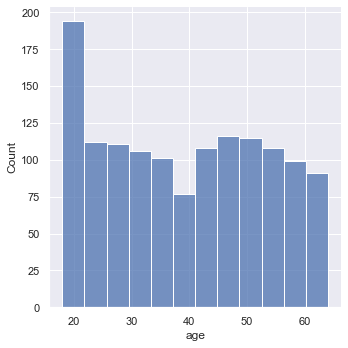

In [203]:
mean_std("age", insurance_df)

#### interpretation:

* mean age fits to the number other studies found for the mean working-age in the Us, 
* standart deviation is high -> representative of diffrent age groups
* spike at 20 

### sex:

In [204]:
sex_count = insurance_df["sex"].value_counts()

In [205]:
sex_percentage_dict = sex_count.map(lambda x: percentage(x, 1337)).to_dict()
print("{} percent are male, {} percent female".format(sex_percentage_dict["male"], sex_percentage_dict["female"]))

50.56095736724009 percent are male, 49.51383694839192 percent female


<function matplotlib.pyplot.show(close=None, block=None)>

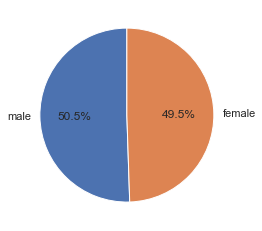

In [206]:
plt.pie(sex_percentage_dict.values(), labels=sex_percentage_dict.keys(),autopct='%1.1f%%', startangle=90)
plt.show

#### Interpretation:

1. evenly spread
2. represenative of both sexes

### BMI:

The mean bmi is 30.663396860986538 and the standart deviation is 6.098186911679017


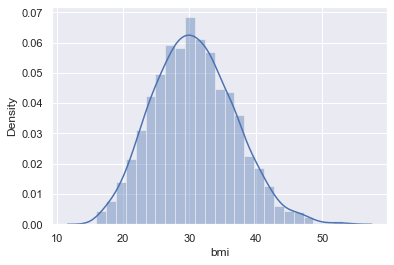

In [207]:
mean_std("bmi", insurance_df, distplot=True)

#### Interpretation:

1. mean bmi is in the overweight range
2. standart deviation is high due to extremes above 50 bmi and under 20
3. --> representative of a broad range of body types

### Children:

The mean children is 1.0949177877429 and the standart deviation is 1.2054927397819095


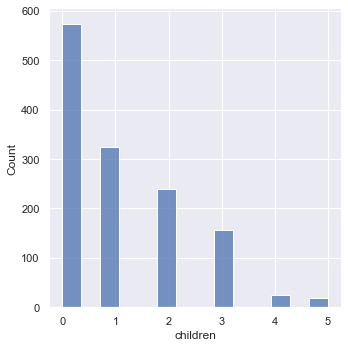

In [208]:
mean_std("children", insurance_df)

#### No child vs. one or more children:

In [209]:
insurance_df["child_no_child"] = insurance_df["children"].map(lambda x: "no child" if x == 0 else "one or more children")

In [210]:
children_count = insurance_df["child_no_child"].value_counts()
children_percentage_dict = children_count.map(lambda x: percentage(x, 1337)).to_dict()
print("{} percent have no child, {} percent have one or more children".format(children_percentage_dict["no child"], children_percentage_dict["one or more children"]))

42.93193717277487 percent have no child, 57.14285714285714 percent have one or more children


<function matplotlib.pyplot.show(close=None, block=None)>

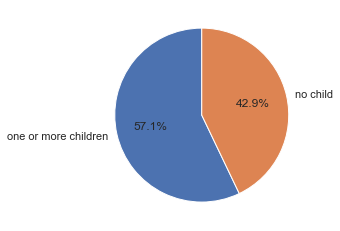

In [211]:
plt.pie(children_percentage_dict.values(), labels=children_percentage_dict.keys(),autopct='%1.1f%%', startangle=90)
plt.show

### Region: 

In [212]:
region_count = insurance_df["region"].value_counts()
region_percent_dict = region_count.map(lambda x: percentage(x, 1337)).to_dict()
print("{} percent come from southeast, {} percent from northwest, {} percent from southwest and {} percent from northeast".format(region_percent_dict["southeast"], region_percent_dict["northwest"], region_percent_dict["southwest"], region_percent_dict["northeast"]))

27.225130890052355 percent come from southeast, 24.30815258040389 percent from northwest, 24.30815258040389 percent from southwest and 24.23335826477188 percent from northeast


<function matplotlib.pyplot.show(close=None, block=None)>

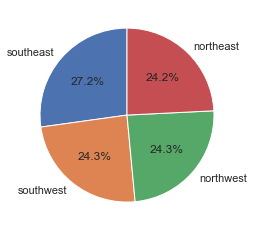

In [213]:
plt.pie(region_percent_dict.values(), labels=region_percent_dict.keys(),autopct='%1.1f%%', startangle=90)
plt.show

#### Interpretation:

1. regions are evenly spread 


## Correlations
#### We want to find out which major aspects influence medical insurance charges to investigate these correlations further in the next segment:

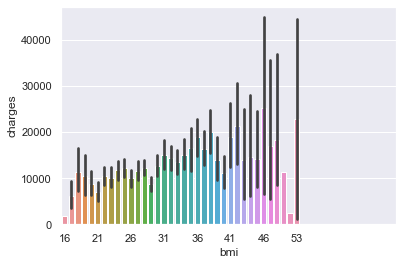

In [214]:
bmi_plot = sns.barplot(insurance_df["bmi"].map(lambda x: round(x)), insurance_df["charges"])
bmi_plot.set_xticks(range(0, 55, 5))

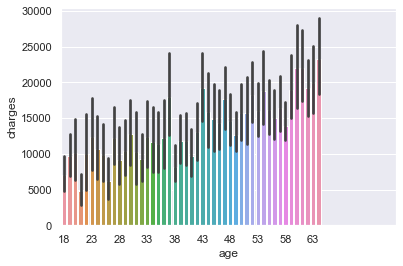

In [215]:
age_plot = sns.barplot(insurance_df["age"], insurance_df["charges"])
age_plot.set_xticks(range(0, 65, 5))

<AxesSubplot:xlabel='children', ylabel='charges'>

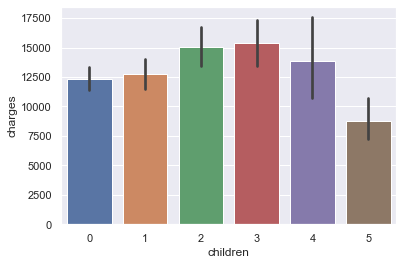

In [216]:
sns.barplot(insurance_df["children"], insurance_df["charges"])

<AxesSubplot:xlabel='region', ylabel='charges'>

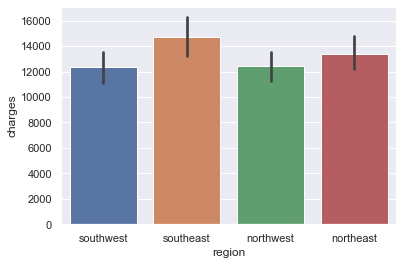

In [217]:
sns.barplot(insurance_df["region"], insurance_df["charges"])

In [218]:
insurance_df["west_east"] = insurance_df["region"].map(lambda x: x[-4:])
east_mean = insurance_df.loc[insurance_df["west_east"] == "east"]["charges"].mean()
west_mean = insurance_df.loc[insurance_df["west_east"] == "west"]["charges"].mean()
diffrence = east_mean - west_mean
print(f"the mean difference between east and west is {diffrence} dollars")

the mean difference between east and west is 1727.2761048910306 dollars


<AxesSubplot:xlabel='smoker', ylabel='charges'>

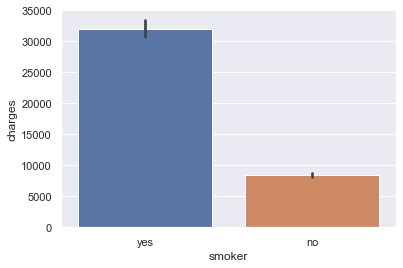

In [219]:
sns.barplot(insurance_df["smoker"], insurance_df["charges"])

<AxesSubplot:xlabel='sex', ylabel='charges'>

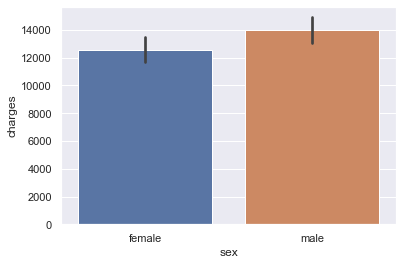

In [220]:
sns.barplot(insurance_df["sex"], insurance_df["charges"])

<AxesSubplot:>

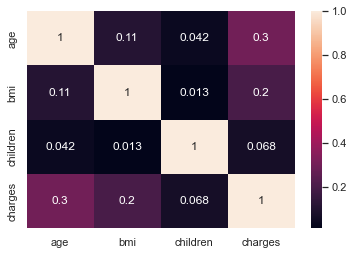

In [221]:
sns.heatmap(insurance_df.corr(), annot=True)

region, smoker and sex cant be displayed via correlation coeficient heatmap cause they are numerical collumns

### Interpretation:

1. bmi: higher bmi seems to raise the charges, average looks like it follows a linear pattern, correlation coeficient of 0.2 -> visible correlation between bmi and charges
2. age: hihger age seems to raise the charges, average looks like it follows a linear pattern, correlation coeficient of 0.3 -> visible correlation between bmi and charges
3. children: charges seem to slightly raise with growing amount of children till the thrid one, then they rapidly fall, extreamly low correlation coeficient
    * does not seem logic, the low amount of data regarding 4 or more children might not be representative
    * not able to draw conclusions about the correlation of age and insurance charges with this dataset
4. region: slight difference in cost between the different regions, mainly between east and west (1727.28 dollars). 
    * Due to the small dataset this project is using, the differnce is to small to make certain conclusions about this difference. It would have to be investigated further in another project with larger amount of data.
5. smoker: data shows the charges being far higher for smoking people
6. sex: data indicates a slight average difference between male and female. Male tend to pay higher charges

#### Main correlations:
To conclude the data on the children showed no clear pattern regarding the medical insurance cost. Sex and region showed small influences on medical insurance charges but our dataset is too small to be certain about these influence. Finaly smoking, age and bmi showed clear pattern regarding the medical insurance charges, as well as noticable higher correlation coeficients(for age and bmi). Thats why we're going to take a closer look at them in the next section to try modeling these correlations.

### Using scatterplots to visualise the actual datapoints:

Text(0.5, 1.0, 'bmi charges correlation')

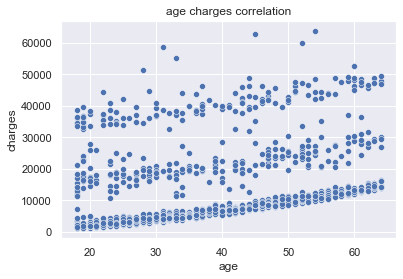

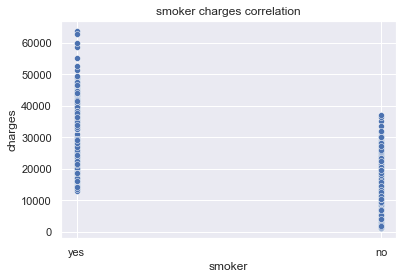

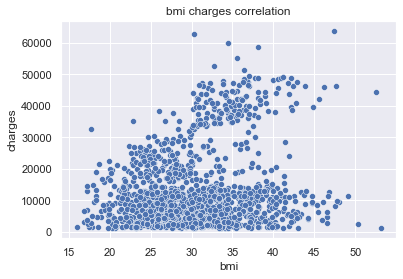

In [222]:
age_charges = sns.scatterplot(insurance_df["age"], insurance_df["charges"])
age_charges.set_title("age charges correlation")
plt.figure()
smoker_charges = sns.scatterplot(insurance_df["smoker"], insurance_df["charges"])
smoker_charges.set_title("smoker charges correlation")
plt.figure()
bmi_charges = sns.scatterplot(insurance_df["bmi"], insurance_df["charges"])
bmi_charges.set_title("bmi charges correlation")

### Interpretation:

1. bmi: datapoints are extreamly far spread out, no pattern recognisable --> pattern of average doesn't represent individuals
    * ==> data can't be modeled
2. age: datapoints are far spread out, but 3 main groups are visible which follow the same linear pattern 
    * ==> we can't build a model that certainly predicts the insurance cost based on the age
    * ==> but we can predict the change by modeling the linear pattern of the groups.
3. smokers: datapoints are far spread out
    * ==> we can't build a model that certainly predicts the insurance cost based on wether someone smokes or not
    * ==> but we can compute the aveage change of charges which can be applied on individuals quite well

## Age charges correlation modeling:

In [223]:
age_groups = pd.DataFrame({"age":[x for x in range(18, 65)], "mean_charges":[x for x in range(18, 65)]})
for age in range(18, 65):
    data = insurance_df.loc[insurance_df["age"] == age]
    age_groups.loc[[age - 18], ["mean_charges"]] = data["charges"].mean()

Text(0.5, 1.0, 'age mean_charges correlation')

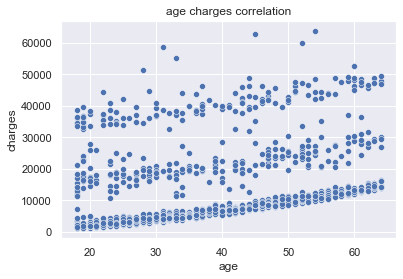

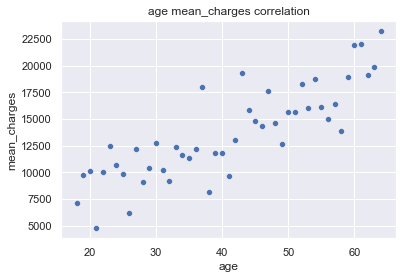

In [224]:
age_charges = sns.scatterplot(insurance_df["age"], insurance_df["charges"])
age_charges.set_title("age charges correlation")
plt.figure()
age_charges = sns.scatterplot(age_groups["age"], age_groups["mean_charges"])
age_charges.set_title("age mean_charges correlation")

In [225]:
x = np.array(age_groups["age"].to_list())
y = np.array(age_groups["mean_charges"].to_list())

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 20)

age_reg = LinearRegression()
age_reg.fit(x_train.reshape(-1, 1), y_train)

LinearRegression()

In [226]:
age_reg.score(x_test.reshape(-1, 1), y_test)

0.7530684073658191

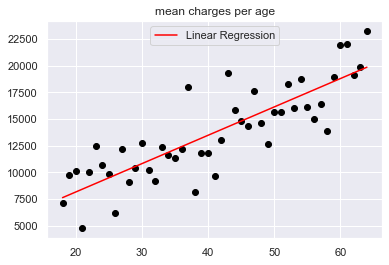

In [227]:
y_predictions = age_reg.predict(x.reshape(-1, 1))
plt.scatter(age_groups["age"], age_groups["mean_charges"], color="black")
plt.title("mean charges per age")
plt.plot(x, y_predictions, color="red", label="Linear Regression")
leg = plt.legend(loc='upper center')
plt.show()

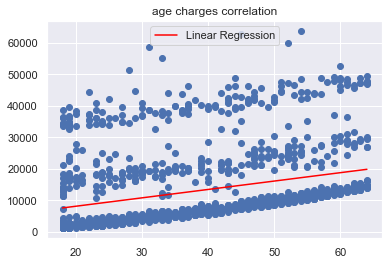

In [228]:
plt.scatter(insurance_df["age"], insurance_df["charges"])
plt.title("age charges correlation")
plt.plot(x, y_predictions, color="red", label="Linear Regression")
leg = plt.legend(loc='upper center')
plt.show()

### Result:

* linear regression we performed on the mean charges performed quite ok with an accuracy of 75 percent
* that model fits on the linear pattern of the 3 different groups visible in the age charges correlation plot like expected
    * ==> the change of the model describing the mean charges can also be applyed on individual cases 

#### figure out slope of the regression model:
with m = (y1 - y2)/(x1 - x2)

In [229]:
slope = (age_reg.predict([[60]]) - age_reg.predict([[30]])) / (60-30)
print(slope)

[266.04855468]


* ==> every year people age raises their medical insurance charges by about 266 dollars

## Smoker charges correlation modeling:

<Figure size 432x288 with 0 Axes>

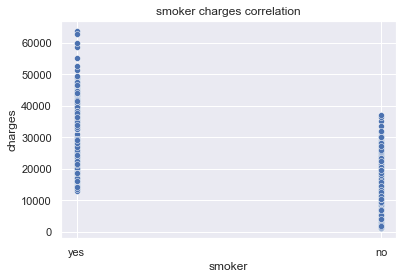

<Figure size 432x288 with 0 Axes>

In [230]:
smoker_charges = sns.scatterplot(insurance_df["smoker"], insurance_df["charges"])
smoker_charges.set_title("smoker charges correlation")
plt.figure()

In [231]:
non_smoker = insurance_df.loc[insurance_df["smoker"] == "no"]
smoker = insurance_df.loc[insurance_df["smoker"] == "yes"]
mean_charge_non_smoker = non_smoker["charges"].mean()
mean_charge_smoker = smoker["charges"].mean()
diference = mean_charges_smoker - mean_charge_non_smoker
print(diference)

23615.96353367665


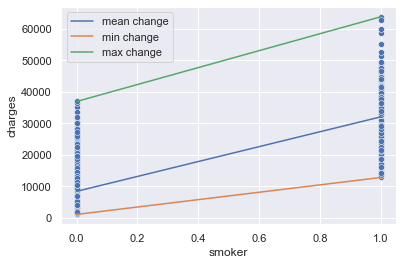

In [232]:
sns.scatterplot(insurance_df["smoker"].map(lambda x: 0 if x == "no" else 1), insurance_df["charges"])
x_values = [0, 1]
y_values = [mean_charge_non_smoker, mean_charge_smoker]
plt.plot(x_values, y_values, label="mean change")
x_values = [0, 1]
y_values = [non_smoker["charges"].min(), smoker["charges"].min()]
plt.plot(x_values, y_values, label="min change")
x_values = [0, 1]
y_values = [non_smoker["charges"].max(), smoker["charges"].max()]
plt.plot(x_values, y_values, label="max change")
leg = plt.legend(loc='upper left')
plt.show()

printed minimal and maximal change together with mean change to see how similar they are

### Result:

* average change of medical insurance charges isn't describing individual cases as well as acpected
* However it still can be aplyed to get an idea of the drastic influence smoking has on your medical insurance charges




# Project Summary:

This project was meant to find and model the main influences on medical insurance charges. Introducing our dataset to matplotlib graphs and further analysing it with pandas and numpy allowed us to find out if our data was representative in all categories. This allowed us to make sure that our findings could be transferred to a broader population. Once finding our data was represented in all aspects we proceeded to find the associations between these variables. After noticing that the variables age, smoking and BMI had the most visible impact on medical insurance charges we took a closer look at these correlations on our approach to model our data. Also, the age and smoker variables did not follow a single linear pattern. However, they showed recurring patterns similar to those of their averages which made it possible to model their average and still be able to transfer that model to individual cases. The linear regression approach to model the average charge per age lead to an accuracy of 75% which is likely because of the small sample size.  The slope of that model provided a fairly accurate representation of the amount an individual would likely pay more for each year that passes (266 USD). Lastly, we tried the same approach of modelling over the average with the smoking variable but it turned out to not be as accurate as expected. So by additionally modelling its minimum and maximum, we can infer that the medical insurance charge drastically increases in practically every case when smoking, the only variance is visible in the amount it increases(from 10000 USD to over 20000 USD).